# Atmospheric River Map

 http://vortex.plymouth.edu/~j_cordeira/ARPortal/EU/Archive/2016121006/html/D1_IVT_0.html#tab
 The integrated vapor transport defines an AR. The region should be continous and $\ge$ 2000 km. The IVT $\ge$ 250 kg m$^{-1}$ s$^{-1}$.

http://journals.ametsoc.org/doi/abs/10.1175/MWR-D-13-00168.1
$$IVT = \frac{1}{g}\int_{p_sfc}^{100\,hPa} q \bf{V} dp$$


 http://apps.ecmwf.int/codes/grib/param-db
 #### Parameters from ECMWF
    - name = 'specific humidity',          shortName = 'q',     [kg kg^-1]
    - name = 'U component of wind',        shortName = 'u',      [m s^-1]
    - name = 'V component of wind',        shortName = 'v',      [m s^-1]



In [1]:
import pygrib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import math
from datetime import date
import calendar
import numpy as np
from plotly.tools import FigureFactory as FF

%matplotlib inline

### Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html

In [2]:
year = '2016'
mon = '12'
day = '25'
time = '18'

In [3]:
### Define colorbar colors
champ = 255.
blue = np.array([1,74,159])/champ           # for the date
# tot. precipitable water (grey scale)
no1 = np.array([255,255,255])/champ
no2 = np.array([250,255,0])/champ
no3 = np.array([255,203,0])/champ
no4 = np.array([255,121,0])/champ
no5 = np.array([255,0,0])/champ
no6 = np.array([148,0,97])/champ
no7 = np.array([101,0,137])/champ

no8 = np.array([130,102,0])/champ



In [4]:
def opengrib(yyyy, mm, dd, tt, pm, path):
    grib = '%s/%s/param_%s_%s%s%s_%s00.grib' % (path,pm,pm,yyyy,mm,dd,tt)
    grbs = pygrib.open(grib)
    return(grbs);

In [5]:
def selectgrb(grbs, sN, tOL, lv):
    val = grbs.select()[0]
    val = grbs.select(shortName = sN, typeOfLevel = tOL, level = lv)[0]
    val = val.values
    return(val);

In [6]:
def shiftgrb(grb,val):
    lat,lon = grb.latlons()
    lons = lon[0,:]
    val,lons = shiftgrid(180., val, lons, start = False)
    lats = lat[:,0]
    
    lons,lats = np.meshgrid(lons,lats)
    plons,plats = m(lons,lats)
    return(plons,plats,val);
    #return(plons,plats,lons,lats,val);

In [7]:
def totalwind(wind_u, wind_v):
    V = np.sqrt(wind_u**2 + wind_v**2)
    theta_deg = (180./math.pi)*np.arctan2(wind_v,wind_u)    
    #convert this wind vector to the meteorological convention of the direction the wind is coming from:
    theta_deg_from = theta_deg + 180.
    # convert angle from "trig" to cardinal
    theta = 90. - theta_deg_from
    return(V,theta);

In [8]:
### OPEN FILES
path = '../test_dataECMWF/SCA/pl'

### PT
parameter = 'q'
grbsSH = opengrib(yyyy = year, mm = mon, dd = day, tt = time, pm = parameter, path = path)

### Wind
parameter = 'uv'
grbsUV = opengrib(yyyy = year, mm = mon, dd = day, tt = time, pm = parameter, path = path)


In [9]:
### Dates for plotting
yr = int(year)
mo = int(mon)
dy = int(day)
my_date = date(yr,mo,dy)
calday = calendar.day_name[my_date.weekday()]
calmon = calendar.month_abbr[mo]

In [10]:
### get the file values into python
# find the first grib message with a matching name:
grbSH = grbsSH.select()[0]
grbUV = grbsUV.select()[0]
## specific humidity
# from Rutz et al. - 2014:
# The integration is done using data at the surface, 50-hPa intervals from the surface to 500 hPa,

# specific humidity q
SH = dict()

# Wind
wind_u = dict()       # U component of wind
wind_v = dict()       # V component of wind
V_lv = dict()            # total wind vector
theta_lv = dict()        # wind direction
IVT_lv = dict()       # Flux in each level trapezodial 
dIVT_lv = dict()      # f(x) in integral 

for i in range(750,1000,50):       # ECMWF has only levels 1000-850 in 50hPa
    lv = i + 50
    SH[lv] = selectgrb(grbsSH, 'q', 'isobaricInhPa', lv) 
    wind_u[lv] = selectgrb(grbsUV, 'u', 'isobaricInhPa', lv)
    wind_v[lv] = selectgrb(grbsUV, 'v', 'isobaricInhPa', lv)
    V_lv[lv], theta_lv[lv] = totalwind(wind_u[lv],wind_v[lv])
    dIVT_lv[lv] = (SH[lv] * V_lv[lv])
    
for i in range(100,800,100):       # ECMWF has from 700 - 100 hPa only in 100hPa steps
    lv = i
    SH[lv] = selectgrb(grbsSH, 'q', 'isobaricInhPa', lv)
    wind_u[lv] = selectgrb(grbsUV, 'u', 'isobaricInhPa', lv)
    wind_v[lv] = selectgrb(grbsUV, 'v', 'isobaricInhPa', lv)
    V_lv[lv], theta_lv[lv] = totalwind(wind_u[lv],wind_v[lv])
    dIVT_lv[lv] = (SH[lv] * V_lv[lv])

In [11]:
for lv in range(800,1000,50):       # ECMWF has only levels 1000-850 in 50hPa
    IVT_lv[lv+25] = (SH[lv] * V_lv[lv] + SH[lv+50] * V_lv[lv+50]) / 2 *5000.
    
for lv in range(100,800,100):       # ECMWF has from 700 - 100 hPa only in 100hPa steps
    IVT_lv[lv+50] = (SH[lv] * V_lv[lv] + SH[lv+100] * V_lv[lv+100])/2 *10000.

In [12]:
## calculate the IVT
g = 9.81      # gravitational acceleration [m s^-2]


IVT = (1/g)*(IVT_lv[150] + IVT_lv[250] + IVT_lv[350] + IVT_lv[450] + IVT_lv[550] + IVT_lv[650] + \
             IVT_lv[750] + IVT_lv[825] + IVT_lv[875] + IVT_lv[925] + IVT_lv[975] )



## calculate the IVT with the Simpsons rule for unequally spaced data
x1 =
x2 = 
x3 =

A = (SH[x3]*V[x3] - SH[x2]*V[x2]) / ((x3-x2) - (x3-x1)) - \
    (SH[x2]*V[x2] - SH[x1]*V[x1]) / ((x2-x1) - (x3-x1))

In [13]:
# calculate IVT components
x_IVT = dict()
y_IVT = dict()
x_tr = dict()    # trapezoidal integegrated x value
y_tr = dict()    # trapezoidal integegrated y 

for lv in range(800,1050,50):       # ECMWF has only levels 1000-850 in 50hPa
    x_IVT[lv] =  -abs(dIVT_lv[lv])* np.sin((math.pi/180)*(theta_lv[lv]))
    y_IVT[lv] =  -abs(dIVT_lv[lv])* np.cos((math.pi/180)*(theta_lv[lv]))

    
for lv in range(100,800,100):       # ECMWF has from 700 - 100 hPa only in 100hPa steps
    x_IVT[lv] =  -abs(dIVT_lv[lv])* np.sin((math.pi/180)*(theta_lv[lv]))
    y_IVT[lv] =  -abs(dIVT_lv[lv])* np.cos((math.pi/180)*(theta_lv[lv]))

for lv in range(800,1000,50):       # ECMWF has only levels 1000-850 in 50hPa
    x_tr[lv+25] = (x_IVT[lv] + x_IVT[lv+50]) / 2 *5000.
    y_tr[lv+25] = (y_IVT[lv] + y_IVT[lv+50]) / 2 *5000.
    
for lv in range(100,800,100):       # ECMWF has from 700 - 100 hPa only in 100hPa steps
    x_tr[lv+50] = (x_IVT[lv] + x_IVT[lv+100]) *10000. 
    y_tr[lv+50] = (y_IVT[lv] + y_IVT[lv+100]) *10000. 

    
IVT_u = (x_tr[150] +  x_tr[250] + x_tr[350] + x_tr[450] + x_tr[550] + \
        x_tr[650] + x_tr[750] + x_tr[825] + x_tr[875] + \
        x_tr[925] + x_tr[975]  )


IVT_v = (y_tr[150] +  y_tr[250] + y_tr[350] + y_tr[450] + y_tr[550] + \
        y_tr[650] + y_tr[750] + y_tr[825] + y_tr[875] + \
        y_tr[925] + y_tr[975]  )






In [14]:
# Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html
m = Basemap(projection='merc', \
            llcrnrlon=-80., urcrnrlon=50., \
            llcrnrlat=15.,urcrnrlat=75., \
            resolution='l')

In [15]:
### Latitudes, Longitudes and shiftgrid
plonsIVT,platsIVT, IVT = shiftgrb(grbUV,IVT)
#plonsIVT,platsIVT,lonsIVT,latsIVT, IVT = shiftgrb(grbUV,IVT)

In [16]:
plonsIU,platsIU, IVT_u = shiftgrb(grbUV,IVT_u)
plonsIV,platsIV, IVT_v = shiftgrb(grbUV,IVT_v)

In [17]:
### find only values larger 250 to plot the IVT flux
larger250 = np.where(IVT[:,:] >= 250.)
print('Values bigger than 250 =', IVT[larger250])
print('The rows are ', larger250[0])
print('The columns are ', larger250[1])



u_flux = IVT_u[larger250[0],larger250[1]]
v_flux = IVT_v[larger250[0],larger250[1]]


lon_flux = plonsIU[larger250[0],larger250[1]]
lat_flux = platsIV[larger250[0],larger250[1]]


Values bigger than 250 = [ 250.68833192  251.30554255  251.78930354 ...,  251.34408932  250.82518323
  250.27235964]
The rows are  [ 145  145  145 ..., 1118 1118 1118]
The columns are  [1237 1238 1239 ...,  211  212  213]


x = np.arange(0,2560)
y = np.arange(0,1280)

lonrange = np.empty((2000,1073),dtype = float)
lonrange[:] = np.NAN

latrange = np.empty((640,2000),dtype = float)
latrange[:] = np.NAN




lonrange = [j for (i,j) in zip(lonsIVT[0,:],x) if  -90<= i <= 60.]
latrange = [j for (i,j) in zip(latsIVT[:,0],y) if  i >= 0. ]

new_lon = lonsIVT[:,lonrange[:]]   # x
new_lat = latsIVT[latrange[:],:]   # y

[lonrange[0]]
#[latrange[0]]

IVT_250 = []
#np.empty((int(latrange[-1]),int(lonrange[-1])))
#IVT_250[:] = np.NAN

for k in range(lonrange[0],lonrange[-1]):
    a = [j for (i,j) in zip(IVT[latrange[0]:latrange[-1],k],x) if i >= 250.]
    if len(a) !=0:
        print()
        #print(a)
        #print(IVT[a,k],lonsIVT[a,k],lats[a,k])
        for j in range(0,int(latrange[-1])):
            IVT_250[j,k] = IVT[a,k]
        
#IVT[latrange[0]:latrange[-1] , lonrange[0]:lonrange[-1]]



In [18]:
### Dates for plotting
yr = int(year)
mo = int(mon)
dy = int(day)
my_date = date(yr,mo,dy)
calday = calendar.day_name[my_date.weekday()]
calmon = calendar.month_abbr[mo]



### Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html




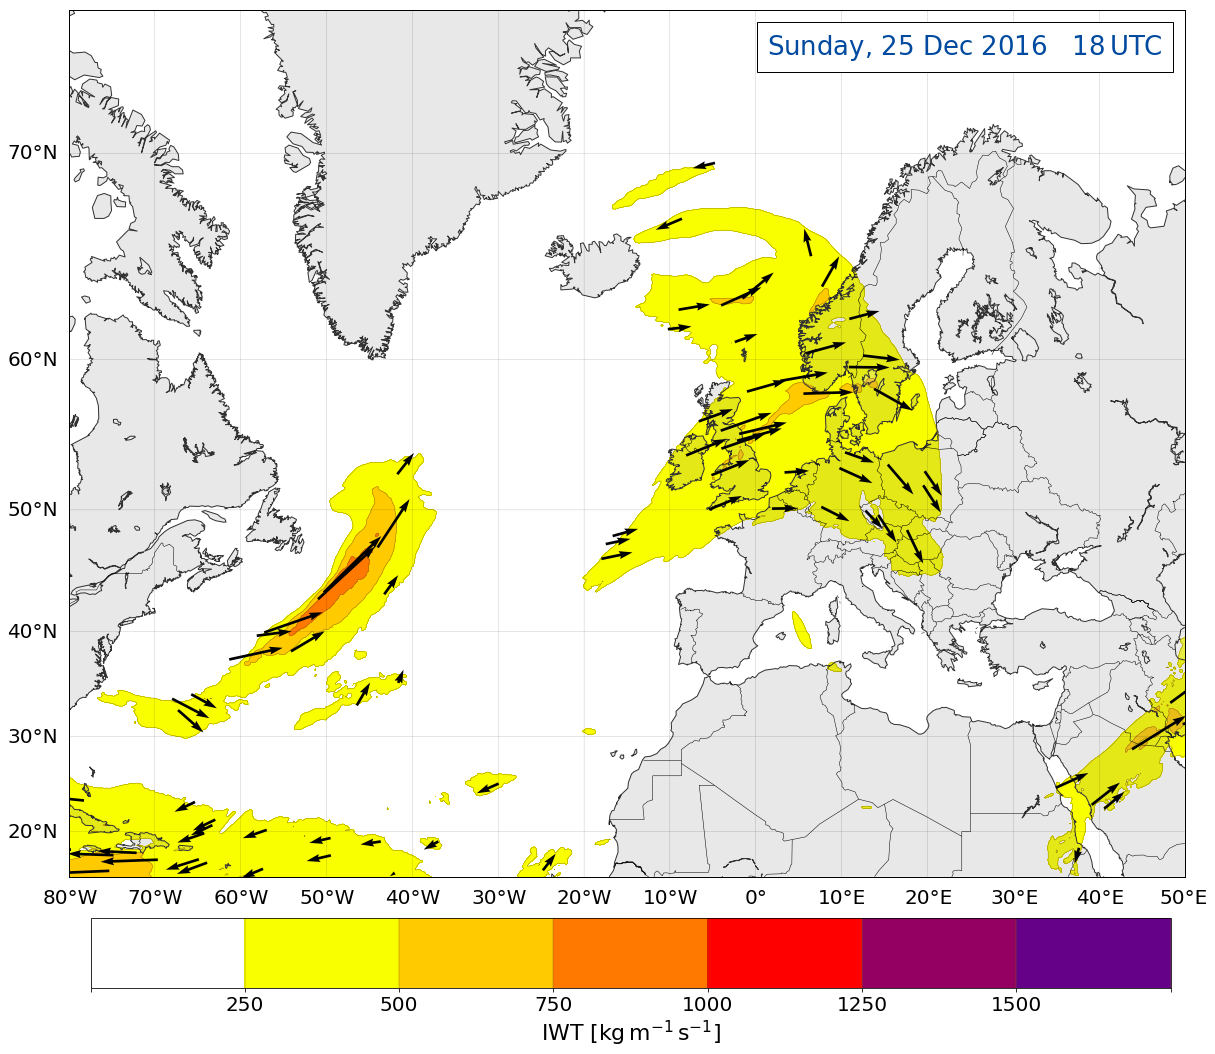

In [19]:

### PLOT FIGURE
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(1,1,1)
#
### Draw Latitude Lines
m.drawparallels(np.arange(-90.,120.,10.),labels=[1,0,0,0],fontsize=20,linewidth=0.2)
#
### Draw Longitude Lines
m.drawmeridians(np.arange(-180.,180.,10.),labels=[0,0,0,1],fontsize=20,linewidth=0.2)
#
### Draw Map
m.drawcoastlines(color=[np.array([50,50,50])/champ])
m.drawmapboundary()
m.drawcountries()
m.fillcontinents(color='grey',alpha=0.18)


##
#
### Plot contour lines for IVT and fill
IVTlevels = np.arange(0,1900,250)
IVTmap = colors.ListedColormap([no1, no2, no3, no4, no5, no6, no7])
norm = colors.BoundaryNorm(boundaries = IVTlevels, ncolors=IVTmap.N)
#cs = m.contourf(plonsUV, platsUV, IVT, IVTlevels, norm = norm, cmap=IVTmap)
cs = m.contourf(plonsIVT, platsIVT, IVT, IVTlevels, norm = norm, cmap=IVTmap)



CS2 = plt.contour(cs, levels=cs.levels,
                  linewidths=0.4,
                  colors=[no8])

# Add arrows to show the IVT vectors
#Q = m.quiver(plonsUV_IVT,platsUV_IVT,u_IVT,v_IVT,scale = 5, scale_units='inches')
# every 20, 35th value
scale = 10000.
#scale = 3000.
i = 1000.
legend_size = i/scale + i
#qv = m.quiver( x[points], y[points], uq_data[points], vq_data[points], scale = scale,scale_units=‘inches’,zorder=6)
#Q = m.quiver(plonsIVT[::20,::35],platsIVT[::20,::35],IVT_u[::20,::35],IVT_v[::20,::35], scale = scale, scale_units='inches',zorder=6)#,\
Q = m.quiver(lon_flux[::700],lat_flux[::700],u_flux[::700],v_flux[::700],scale = scale, scale_units='inches',pivot='middle',zorder=6)#,\


# make quiver key
#qk = plt.quiverkey(Q, 0.15, 0.3, 500, '500kg$\,$m$^{-1}\,$s$^{-1}$', labelpos = 'W')
#qk = plt.quiverkey(Q, 0.8, 0.8, legend_size, '500kg$\,$m$^{-1}\,$s$^{-1}$', labelpos = 'E', coordinates ='figure')



#
### Add Colorbar
cbaxes = fig.add_axes([0.14, 0.03, .75, .06] )   #[left, bottom, width, height] 
cbar = plt.colorbar(cs,orientation='horizontal',cax = cbaxes)#, cax = cbaxes)#, shrink=0.5)
cbar.ax.set_xlabel('IWT [kg$\,$m$^{-1}\,$s$^{-1}$]',fontsize='22')
cbar.ax.set_xticklabels(['', '250', '500', '750', '1000', '1250', '1500'])  # horizontal colorbar
cbar.ax.tick_params(labelsize=20) 
# Make a colorbar for the ContourSet returned by the contourf call.
# Add the contour line levels to the colorbar
cbar.add_lines(CS2)

#cbar.ax.set_aspect(200)


#
### Add Textbox
ax.text(0.98,0.94, '%s, %s %s %s   %s$\,$UTC' %(calday, day, calmon, year, time),     # x, y
            verticalalignment = 'bottom',  horizontalalignment='right',
            transform = ax.transAxes,
            color =blue, fontsize=26,
            bbox={'facecolor':'white','alpha':1., 'pad':10})
#
### Add Title
#fig.suptitle('Integrated Vapor Transport', fontsize=20, fontweight='bold') 
#ax.set_title('MSLP (solid contours every 4$\,$hPa), \n 250$\,$hPa wind speed (m$\,$s$^{-1}$, shaded according to the color bar), \n 1000-500$\,$hPa thickness (dashed contours every 6 dam), \n total precipitable water (mm, shaded according to gray scale)',             fontsize=13)

### Save
plt.savefig('../synoptic_figs/Atm_Riv/%s%s%s_%s.png' % (year, mon, day,time))
## with header
#plt.savefig('../synoptic_figs/Atm_Riv/%s%s%s_%s_header.png' % (year, mon, day,time))

plt.show()
plt.close()